 ! pip install psycopg2 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras 

In [2]:
def getRegisteredUsersCount():
    query = '''SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

registered_users_count = pd.DataFrame(getRegisteredUsersCount())

In [3]:
registered_users_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   registration_date       30 non-null     object
 1   registered_users_count  30 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 608.0+ bytes


In [4]:
registered_users_count['registration_date'] = pd.to_datetime(registered_users_count['registration_date'])

In [5]:
registered_users_count['registered_users_count'].sum()

100423

In [6]:
registered_users_count.head()

,registration_date,registered_users_count
0,2019-06-01,4833
1,2019-06-02,5255
2,2019-06-03,4193
3,2019-06-04,4194
4,2019-06-05,3998


In [7]:
def getActiveUsersCountWithCohorts():
    query = '''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

active_users_count_with_cohorts = pd.DataFrame(getActiveUsersCountWithCohorts())

In [8]:
active_users_count_with_cohorts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   activity_date       930 non-null    object
 1   registration_date   930 non-null    object
 2   active_users_count  930 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.9+ KB


In [9]:
for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts[col] = pd.to_datetime(active_users_count_with_cohorts[col])

In [10]:
active_users_count_with_cohorts.head()

,activity_date,registration_date,active_users_count
0,2019-06-01,2019-06-01,1651
1,2019-06-02,2019-06-01,1429
2,2019-06-02,2019-06-02,1933
3,2019-06-03,2019-06-01,1021
4,2019-06-03,2019-06-02,1550


In [11]:
retention_table = active_users_count_with_cohorts.merge(registered_users_count,on=['registration_date'],how='left')
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count
0,2019-06-01,2019-06-01,1651,4833
1,2019-06-02,2019-06-01,1429,4833
2,2019-06-02,2019-06-02,1933,5255
3,2019-06-03,2019-06-01,1021,4833
4,2019-06-03,2019-06-02,1550,5255


In [12]:
retention_table['retention_rate'] = retention_table['active_users_count'] / retention_table['registered_users_count']
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate
0,2019-06-01,2019-06-01,1651,4833,0.341610
1,2019-06-02,2019-06-01,1429,4833,0.295676
2,2019-06-02,2019-06-02,1933,5255,0.367840
3,2019-06-03,2019-06-01,1021,4833,0.211256
4,2019-06-03,2019-06-02,1550,5255,0.294957


In [13]:
retention_table['lifetime'] = retention_table['activity_date'] - retention_table['registration_date']
retention_table['lifetime'].head()

0   0 days
1   1 days
2   0 days
3   2 days
4   1 days
Name: lifetime, dtype: timedelta64[ns]

In [14]:
retention_table['lifetime'] = retention_table['lifetime']/np.timedelta64(1,'D')
retention_table['lifetime'] = retention_table['lifetime'].astype(int) # Приведем тип к целому числу
retention_table['lifetime'].head()

0    0
1    1
2    0
3    2
4    1
Name: lifetime, dtype: int32

In [15]:
retention_pivot = retention_table.pivot_table(index='registration_date',columns='lifetime',values='retention_rate',aggfunc='sum')
retention_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-06-01,0.341610,0.295676,0.211256,0.175667,0.143596,0.134906,0.121664,0.112766,0.110904,0.099938,...,0.060418,0.061246,0.058763,0.055245,0.056487,0.050693,0.049659,0.050693,0.042003,0.028968
2019-06-02,0.367840,0.294957,0.221313,0.188202,0.164225,0.145576,0.130923,0.129971,0.121598,0.109610,...,0.073073,0.071931,0.068506,0.062797,0.061656,0.062797,0.063178,0.060514,0.044719,0.028925
2019-06-03,0.341522,0.296685,0.207727,0.173384,0.150727,0.123062,0.118054,0.115430,0.111376,0.099213,...,0.065109,0.064870,0.063916,0.057238,0.056284,0.051753,0.052707,0.051991,0.041975,0.028858
2019-06-04,0.351216,0.296853,0.229852,0.180019,0.147592,0.133047,0.135670,0.121841,0.106581,0.098236,...,0.063662,0.060324,0.058417,0.053648,0.051502,0.051979,0.051264,0.047926,0.036242,0.023605
2019-06-05,0.337419,0.305403,0.223112,0.172336,0.147324,0.140570,0.131816,0.118059,0.108304,0.097799,...,0.066033,0.064282,0.060030,0.056278,0.054527,0.054527,0.053527,0.051026,0.037519,0.027514
2019-06-06,0.362845,0.306551,0.208802,0.178864,0.169396,0.141505,0.131013,0.117707,0.109519,0.098516,...,0.066018,0.063715,0.064483,0.057318,0.056551,0.055015,0.055527,0.055271,0.045803,0.030194
2019-06-07,0.370719,0.294691,0.219290,0.190386,0.171222,0.147345,0.129752,0.120955,0.108702,0.106189,...,0.068803,0.068803,0.068175,0.068175,0.063776,0.064719,0.062834,0.059692,0.045240,0.027961
2019-06-08,0.361902,0.330097,0.251423,0.204553,0.179444,0.156344,0.144961,0.141948,0.127218,0.116170,...,0.076666,0.071979,0.072648,0.071979,0.067626,0.066622,0.066622,0.065618,0.052896,0.037496
2019-06-09,0.363961,0.321811,0.234835,0.192685,0.165923,0.149643,0.143845,0.136039,0.118198,0.113069,...,0.081401,0.074710,0.071142,0.066905,0.068020,0.065343,0.066236,0.062444,0.049286,0.031891


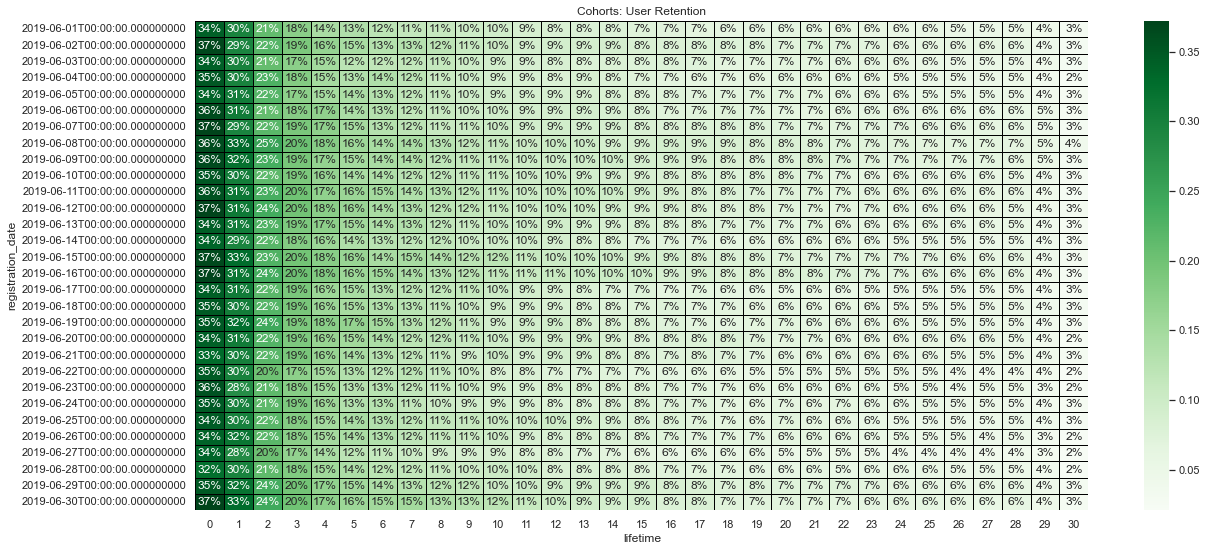

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, mask=retention_pivot.isnull(), annot=True, fmt='.0%', linewidths=0.5, linecolor='black', cmap="Greens");

<AxesSubplot:xlabel='registration_date'>

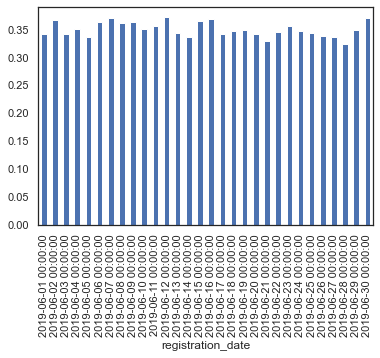

In [17]:
retention_pivot[0].plot.bar()

<AxesSubplot:xlabel='registration_date'>

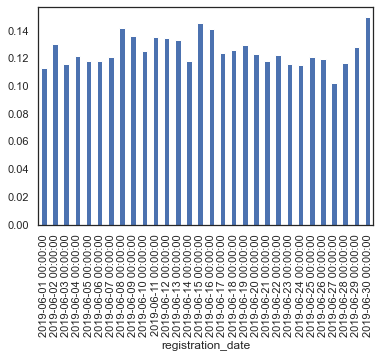

In [18]:
retention_pivot[7].plot.bar()

In [19]:
retention_pivot[7]['2019-06-30']/retention_pivot[7]['2019-06-01']

1.3244076718481195

In [34]:
def getRevenue():
    query = '''SELECT re.date, r.registration_date, count(distinct(re.user_id)) as users_count_with_revenue, sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

revenue = pd.DataFrame(getRevenue())

In [35]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      833 non-null    object 
 1   registration_date         833 non-null    object 
 2   users_count_with_revenue  833 non-null    int64  
 3   revenue                   833 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 26.2+ KB


In [36]:
for col in ['date','registration_date']:
    revenue[col] = pd.to_datetime(revenue[col])

In [37]:
revenue.head()

,date,registration_date,users_count_with_revenue,revenue
0,2019-06-01,2019-06-01,1082,1611.860
1,2019-06-02,2019-06-01,928,317.738
2,2019-06-02,2019-06-02,1257,1305.220
3,2019-06-03,2019-06-01,623,192.273
4,2019-06-03,2019-06-02,1008,554.859


In [38]:
revenue['revenue'].sum()

79685.865447

In [39]:
registered_users_count['registered_users_count'].sum()

100423

In [40]:
revenue['revenue'].sum()/registered_users_count['registered_users_count'].sum()

0.7935021404160402

In [27]:
revenue = revenue.rename(columns={'date':'activity_date'})

In [28]:
retention_table_with_revenue = retention_table.merge(revenue,on=['registration_date','activity_date'],how='left')

In [29]:
retention_table_with_revenue.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue
0,2019-06-01,2019-06-01,1651,4833,0.341610,0,1082.0,1611.860
1,2019-06-02,2019-06-01,1429,4833,0.295676,1,928.0,317.738
2,2019-06-02,2019-06-02,1933,5255,0.367840,0,1257.0,1305.220
3,2019-06-03,2019-06-01,1021,4833,0.211256,2,623.0,192.273
4,2019-06-03,2019-06-02,1550,5255,0.294957,1,1008.0,554.859


In [30]:
retention_table_with_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 930 entries, 0 to 929
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   activity_date             930 non-null    datetime64[ns]
 1   registration_date         930 non-null    datetime64[ns]
 2   active_users_count        930 non-null    int64         
 3   registered_users_count    930 non-null    int64         
 4   retention_rate            930 non-null    float64       
 5   lifetime                  930 non-null    int32         
 6   users_count_with_revenue  833 non-null    float64       
 7   revenue                   833 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int32(1), int64(2)
memory usage: 61.8 KB


In [31]:
for col in ['revenue','users_count_with_revenue']:
    retention_table_with_revenue[col] = retention_table_with_revenue[col].fillna(0)

In [32]:
retention_table_with_revenue['users_count_with_revenue'] = retention_table_with_revenue['users_count_with_revenue'].astype(int)

In [33]:
retention_table_with_revenue['arpu'] = retention_table_with_revenue['revenue']/retention_table_with_revenue['users_count_with_revenue']